In [26]:
import matplotlib
from matplotlib import pyplot as plt
%matplotlib inline

In [28]:
class f2d():
    def __init__(self,filepath):

        self.pool=[] # sampleI shape like datas
        self.sampleI=[0, #timeStamp
                      0,0,0,0,0, # Counts of flavor0 ~ flavor15
                      0,0,0,0,0,
                      0,0,0,0]
        
        self.legi={"flavor1":1,"flavor2":2,"flavor3":3,"flavor4":4,"flavor5":5,"flavor6":6,"flavor7":7,
                   "flavor8":8,"flavor9":9,"flavor10":10,"flavor11":11,"flavor12":12,"flavor13":13,
                   "flavor14":14,"flavor15":15}
        self.linesREG={0:0,
                       1:1,2:1,
                       3:2,4:2,5:2,
                       6:3,7:3,8:3,9:3,10:3}
        
        self.lines=list([])
        self.linescount=dict({})
        self.resData=[]
        
        with open(filepath, 'r') as f:
            lines = f.readlines()
        
        self.stime=self.date2read(lines[0].strip().split('\t')[2])
        
        for line in lines:
            self.mkpool(line)
        #for i in range(len(self.pool)):
        #    self.pool[i][0]=i+1
        
        self.dataLine()
        self.regulias()
    
    def regulias(self):
        for line in self.pool:
            tmline=[]
            for each in line:
                if self.linesREG.has_key(each):
                    tmline.append(self.linesREG[each])
                else:
                    tmline.append(4)
            self.resData.append(tmline)
                
    
    def dataLine(self):
        self.lines=[]
        S=set({})
        for line in self.pool:
            S.update(line)
            for each in line:
                if self.linescount.has_key(each):
                    self.linescount[each]+=1
                else:self.linescount[each]=1
        self.lines.extend(S)
     
    def time2read(self,dt):
        dt = dt.split('\t')[0]
        return time.mktime(time.strptime(dt,'%Y-%m-%d %H:%M:%S'))
    
    def date2read(self,dt):
        dt = dt.split()[0]
        return time.mktime(time.strptime(dt,'%Y-%m-%d')) # %H:%M:%S'))
    
    def hour2read(self,dt):
        dt = dt.split(":")[0]
        return time.mktime(time.strptime(dt,'%Y-%m-%d %H')) #:%M:%S'))

    def timeMh(self,d1,d2):
        return int((d1-d2)/604800) #a week
        #return int((d1-d2)/3600) #a hour
        #return int((d1-d2)/86400) #a day
    
    def mkpool(self,raw):

        flavor,tm=raw.strip().split("\t")[1:]
        #print tm
        TM=self.time2read(tm)
        
        if flavor in self.legi:
            hourTM=self.timeMh(TM,self.stime)
            #pint hourTM
            while hourTM - len(self.pool) >= 0:
                sample = self.sampleI[:]
                self.pool.append(sample)
            
            
            self.pool[hourTM][self.legi[flavor]-1]+=1
    
    def appendDat(self,filepath):
        with open(filepath, 'r') as f:
            lines = f.readlines()
        
        for line in lines:
            self.mkpool(line)
        self.regulias()
        self.dataLine()
        #for i in range(len(self.pool)):
        #    self.pool[i][0]=i+1

In [ ]:
import os
import time

class prePro():
    def __init__(self,ecsDataPath,inputFilePath,resultFilePath):        
        InputInfos=self.readInput(inputFilePath)
        self.phsDev=InputInfos[0] # (int(cpu),int(ram),int(disk))
        self.virDevs=InputInfos[1]# dict[ID]:(int(cpus),int(rams))
        self.firstCare=InputInfos[2]# CPU or MEM
        self.predicStrTime=InputInfos[3]# timestamp
        self.predicEndTime=InputInfos[4]# timestamp
        
        self.predicLength=self.predicEndTime-self.predicStrTime
        
        self.pool=[[],[],[],[],[],
                   [],[],[],[],[],
                   [],[],[],[],[]]

        self.legi={"flavor1":0,"flavor2":1,"flavor3":2,"flavor4":3,"flavor5":4,
                   "flavor6":5,"flavor7":6,"flavor8":7,"flavor9":8,"flavor10":9,
                   "flavor11":10,"flavor12":11,"flavor13":12,
                   "flavor14":13,"flavor15":14}
        # Counts of flavor0 ~ flavor15
        with open(ecsDataPath, 'r') as f:
            lines = f.readlines()  
        self.startime=self.date2read(lines[0].strip().split('\t')[2])
        self.endstime=self.date2read(lines[-1].strip().split('\t')[2])+86400
        for line in lines:
            self.mkpool(line)
        
        #self.regulas()#print(self.pool)
        self.results=self.predict()
        #print(self.results)
        self.putPhs(resultFilePath)
        
    def regulas(self):
        for each in range(15):
            if self.pool[each] != []:
                avr = sum(self.pool[each])/float(len(self.pool[each]))
                for i in range(len(self.pool[each])):
                    if self.pool[each][i] > 3 * avr:
                        #self.pool[each][i] = round(self.pool[each][i] * 0.5) 
                        self.pool[each][i] = round(self.pool[each][i])        

                        
    def date2read(self,dt):
        dt = dt.split()[0]
        return time.mktime(time.strptime(dt,'%Y-%m-%d'))    
    
    def readTime(self,timeStr):
        return time.mktime(time.strptime(timeStr,'%Y-%m-%d %H:%M:%S'))

    def time2read(self,dt):
        dt = dt.split('\t')[0]
        return time.mktime(time.strptime(dt,'%Y-%m-%d %H:%M:%S'))

    def timeMh(self,d1,d2):
        #return int((d1-d2)/604800) #a week
        #return int((d1-d2)/3600) #a hour
        return int((d1-d2)/(self.predicLength*0.5)) #a day
        #return int((d1-d2)/(self.predicLength)) #a day

    def readInput(self,inputFilePath):
        if os.path.exists(inputFilePath):
            with open(inputFilePath,'r') as f:
                cpu,ram,disk=f.readline().strip().split()
                f.readline()
                phsDev=(int(cpu),int(ram),int(disk))
                virDevCount=int(f.readline().strip())
                virDevs={}
                for i in range(virDevCount):
                    Id,cpus,rams=f.readline().strip().split()
                    virDevs[Id]=(int(cpus),int(rams))
                f.readline()
                firstCare=f.readline().strip()
                f.readline()
                predicStrTime=self.readTime(f.readline().strip())
                predicEndTime=self.readTime(f.readline().strip())
                #print(phsDev,virDevs,firstCare,predicStrTime,predicEndTime)
            return phsDev,virDevs,firstCare,predicStrTime,predicEndTime

        else:
            print('file not exist: ' + file_path)
            return None
    
    def mkpool(self,raw):
        flavor,tm=raw.strip().split("\t")[1:]
        TM=self.time2read(tm)
        if flavor in self.virDevs:
            hourTM=self.timeMh(TM,self.startime)
            while hourTM - len(self.pool[self.legi[flavor]]) >= 0:
                self.pool[self.legi[flavor]].append(0)       
            self.pool[self.legi[flavor]][hourTM]+=1
            
    def predict(self):
        predicts={}
        predTime=self.predicEndTime - self.predicStrTime
        dataTime=self.endstime-self.startime     
        for i in self.virDevs:

            Ti=GradianDecent(self.pool[self.legi[i]],4800,10**-6)
            Ti.Train()
            Xi=int(dataTime/float(predTime*0.5))
            #Xi=int(dataTime/predTime)

            #print("Xi",Xi)
            #print("J",Ti.J)
            index=len(self.pool[self.legi[i]])
            errors = []
            for ineach in range(index):
                errors.append((round(Ti.h(ineach))-self.pool[self.legi[i]][ineach] )/ float(index))
            
            print(i,sum([abs(each) for each in errors]))
            plt.plot(errors)
            
            gdcounts1= round(Ti.h(Xi))
            # pre_1 = self.pool[self.legi[i]][-2]
            gdcounts2= round(Ti.h(Xi+1))
            gdpredict = int(round(gdcounts1+gdcounts2))
            #pre_2 = self.pool[self.legi[i]][-1]

            predicts[i]=int(round(gdpredict))
            #predicts[i]=int(gdcounts1)

        return predicts
   
    def putPhs(self,resultFile):
        results=self.results.copy()
        Hdev=list(self.phsDev)
        HDs={0:list(Hdev[:2])}
        HDf={0:{"flavor1":0,"flavor2":0,"flavor3":0,"flavor4":0,"flavor5":0,
                "flavor6":0,"flavor7":0,"flavor8":0,"flavor9":0,"flavor10":0,
                "flavor11":0,"flavor12":0,"flavor13":0,"flavor14":0,"flavor15":0}}
        
        def selectHard(hdf,hds,dev):
            for i in hds:
                if hds[i][0] > self.virDevs[dev][0] and hds[i][1] > self.virDevs[dev][1]/1024.0:
                    return i
            hds[len(hds)]=list(Hdev[:2])
            hdf[len(hdf)]={"flavor1":0,"flavor2":0,"flavor3":0,"flavor4":0,"flavor5":0,
                           "flavor6":0,"flavor7":0,"flavor8":0,"flavor9":0,"flavor10":0,
                           "flavor11":0,"flavor12":0,"flavor13":0,"flavor14":0,"flavor15":0}

            return len(hds)-1

        def isHave(predev=self.results):
            for i in predev:
                if predev[i]>0:
                    return True
            return False

        def genKeys(predev=self.results):
            keys = ["flavor15","flavor14","flavor13","flavor12","flavor11","flavor10","flavor9","flavor8","flavor7","flavor6","flavor5","flavor4","flavor3","flavor2","flavor1"]
            res = []
            #print predev
            for key in keys:
                if key in predev.keys():
                    for i in range(predev[key]):
                        res.append(key)
            return res

        def sv(hdf=HDf,hds=HDs,predev=results):
            keys = genKeys()
            firstC = 0 
            if firstC == 0 or firstC == 1:
                while isHave(predev):
                    isPlace = False
                    for i in hds:             
                        for key in keys:            
                            if predev[key] > 0:
                                if hds[i][0] >= self.virDevs[key][0]:      
                                    if hds[i][1] >= self.virDevs[key][1]/1024.0:
                                        cpu,ram=self.virDevs[key]
                                        hds[i][0] -= cpu
                                        hds[i][1] -= ram/1024.0
                                        hdf[i][key] += 1
                                        predev[key] -= 1
                                        keys.remove(key)
                                        isPlace = True
                    if isPlace == False :
                        hds[len(hds)]=Hdev[:]
                        hdf[len(hdf)]={"flavor1":0,"flavor2":0,"flavor3":0,"flavor4":0,"flavor5":0,"flavor6":0,"flavor7":0,"flavor8":0,"flavor9":0,"flavor10":0,"flavor11":0,"flavor12":0,"flavor13":0,"flavor14":0,"flavor15":0}

        f=open(resultFile,"w")
        totals = int(sum([i for i in results.values()]))
        f.writelines([str(totals),'\n'])
        
        for ID,Count in results.iteritems():
            f.writelines([ID," ",str(int(Count)),'\n'])
        sv()
        f.writelines(['\n'])
        
        f.writelines([str(len(HDf)),'\n'])
        for each in HDf:
            f.writelines([str(each+1)])
            for i in HDf[each]:
                if i in results:
                    f.writelines([' ',i,' ',str(int(HDf[each][i]))])
            f.writelines(['\n'])
        f.close()

class GradianDecent():
    def __init__(self,Y,trainL=4800,learningRate=10**-6,
                 A = 0.0000057142857142857145,
                 B = 0.011285714285714285,
                 C = 1.0):

        self.X=range(len(Y))
        self.Y=Y
        self.m=len(self.Y)
        self.trainL=trainL
        self.learningRate=learningRate

        self.A = A 
        self.B = B
        self.C = C

        self.J=[]
        
    def Train(self):
        for each in range(self.trainL):
            ja=self.JFA(self.X,self.Y,self.A,self.B,self.C,self.m)
            jb=self.JFB(self.X,self.Y,self.A,self.B,self.C,self.m)
            jc=self.JFC(self.X,self.Y,self.A,self.B,self.C,self.m)
            #print("ja",ja,"\tjb",jb,"\tjc",jc)
            self.A = self.A - self.learningRate * ja
            self.B = self.B - self.learningRate * jb
            self.C = self.C - self.learningRate * jc
            self.J.append(self.Cost(self.X,self.Y,self.A,self.B,self.C,self.m))
    
    def h(self,x):
        return  self.A*x **2  + self.B*x + self.C

    def JFA(self,X,Y,A,B,C,m):
        s=0.
        for i in range(m):
            s += 2*X[i] **2 *( A*X[i] **2  + B*X[i] + C - Y[i])
        return s/float(m)

    def JFB(self,X,Y,A,B,C,m):
        s=0.
        for i in range(m):
            s += 2*X[i] *( A*X[i] **2  + B*X[i] + C - Y[i])
        return s/float(m)

    def JFC(self,X,Y,A,B,C,m):
        s=0.
        for i in range(m):
            s +=  2*(A*X[i] **2  + B*X[i] + C - Y[i])
        return s/float(m)

    def Cost(self,X,Y,A,B,C,m):
        s=0.
        for i in range(m):
            s +=  abs(A*X[i] **2  + B*X[i] + C - Y[i])
        return s/float(m)

('flavor3', 2.125)
('flavor2', 4.125)
('flavor1', 0.625)
('flavor5', 7.125)
('flavor4', 0.75)


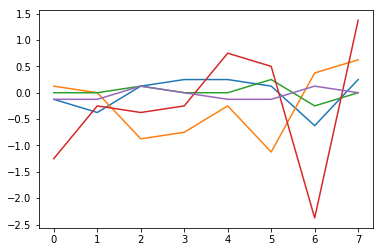

In [57]:
# coding=utf-8
import sys
import os
import time
import numpy as np
#from predictor import prePro

        
if __name__ == "__main__":

    ecsDataPath = "example/data_2015_4.txt"
    inputFilePath = "example/input_5flavors_cpu_7days.txt"
    resultFilePath = "../x2-regression/src/ecs/result"
    result=prePro(ecsDataPath,inputFilePath,resultFilePath)

In [46]:
oData = f2d("example/data_2015_4.txt")
oMat = np.mat(oData.pool)
testData = f2d("example/data_2015_5.txt")
testMat = np.mat(testData.pool)

In [37]:
for i in result.pool:
    print(i)

[1, 0, 1, 0, 0, 0, 1, 1, 2, 0, 1, 0, 5, 0, 4]
[0, 0, 0, 1, 0, 9, 8, 2, 4, 4, 16, 1, 8, 0, 6, 4]
[1, 1, 3, 1, 0, 0, 0, 0, 0, 0, 1, 1, 2, 7, 0, 2]
[1, 1, 0, 2, 0, 0, 1, 0, 2, 0, 1, 1, 0, 0, 0, 1]
[1, 10, 3, 1, 4, 3, 0, 9, 2, 4, 1, 13, 22, 22, 22, 1]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]


In [32]:
j=0
for i in testData.pool[0]:
    j += 1
    print(j,i)

(1, 3)
(2, 4)
(3, 0)
(4, 1)
(5, 20)
(6, 22)
(7, 3)
(8, 24)
(9, 7)
(10, 0)
(11, 17)
(12, 8)
(13, 0)
(14, 3)
(15, 0)
